In [2]:
import zipfile
import os

def unzip_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Paths to the zip files
temp_slice_zip = 'temp_slice.zip'
model_weight_zip = 'model_weight.zip'

# Paths to extract the contents
temp_slice_extract_to = 'temp_slice'
model_weight_extract_to = 'model_weight'

# Create directories if they don't exist
os.makedirs(temp_slice_extract_to, exist_ok=True)
os.makedirs(model_weight_extract_to, exist_ok=True)

# Unzip the folders
unzip_folder(temp_slice_zip, temp_slice_extract_to)
unzip_folder(model_weight_zip, model_weight_extract_to)

print("Descompresión completada.")

Descompresión completada.


In [5]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from torch.autograd import Variable
import pathlib
from PIL import Image
from IPython.display import display
import random
import math

# Configuración de CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Definición del dataset
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Modified: Use pathlib.Path.rglob to find PNG images recursively
        self.image_paths = list(pathlib.Path(root_dir).rglob('*.png'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Carga del dataset
# Modified: Updated root_dir to 'temp_slice'
dataset = BrainTumorDataset(root_dir='temp_slice', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

2. Definición del modelo GAN Vamos a definir el generador y el discriminador para la GAN:

In [9]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

3. Entrenamiento del modelo Vamos a definir el bucle de entrenamiento para la GAN:

In [10]:
# Inicialización de los modelos
netG = Generator().to(device)
netD = Discriminator().to(device)

# Inicialización de los optimizadores
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Definición de la función de pérdida
criterion = nn.BCELoss()

# Etiquetas reales y falsas
real_label = 1
fake_label = 0

# Bucle de entrenamiento
num_epochs = 25
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Actualización del discriminador con datos reales
        netD.zero_grad()
        real_images = data.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()
        D_x = output.mean().item()

        # Actualización del discriminador con datos falsos
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        # Actualización del generador
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Imprimir estadísticas de entrenamiento
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

[0/25][0/3] Loss_D: 1.6661 Loss_G: 1.6211 D(x): 0.3566 D(G(z)): 0.4573 / 0.2038
[1/25][0/3] Loss_D: 0.1219 Loss_G: 4.4087 D(x): 0.9992 D(G(z)): 0.1132 / 0.0132
[2/25][0/3] Loss_D: 0.0663 Loss_G: 4.9274 D(x): 0.9959 D(G(z)): 0.0600 / 0.0078
[3/25][0/3] Loss_D: 0.0487 Loss_G: 5.2972 D(x): 0.9890 D(G(z)): 0.0366 / 0.0055
[4/25][0/3] Loss_D: 0.0324 Loss_G: 5.6623 D(x): 0.9929 D(G(z)): 0.0248 / 0.0038
[5/25][0/3] Loss_D: 0.0327 Loss_G: 5.7626 D(x): 0.9947 D(G(z)): 0.0270 / 0.0035
[6/25][0/3] Loss_D: 0.0207 Loss_G: 5.8633 D(x): 0.9961 D(G(z)): 0.0166 / 0.0031
[7/25][0/3] Loss_D: 0.0152 Loss_G: 6.3058 D(x): 0.9969 D(G(z)): 0.0120 / 0.0021
[8/25][0/3] Loss_D: 0.0108 Loss_G: 6.8616 D(x): 0.9958 D(G(z)): 0.0066 / 0.0012
[9/25][0/3] Loss_D: 0.0143 Loss_G: 6.4885 D(x): 0.9971 D(G(z)): 0.0114 / 0.0016
[10/25][0/3] Loss_D: 0.0137 Loss_G: 6.5313 D(x): 0.9972 D(G(z)): 0.0108 / 0.0016
[11/25][0/3] Loss_D: 0.0075 Loss_G: 6.9805 D(x): 0.9979 D(G(z)): 0.0053 / 0.0010
[12/25][0/3] Loss_D: 0.0125 Loss_G: 6.

4. Evaluación y generación de imágenes Finalmente, vamos a generar algunas imágenes para evaluar el modelo:

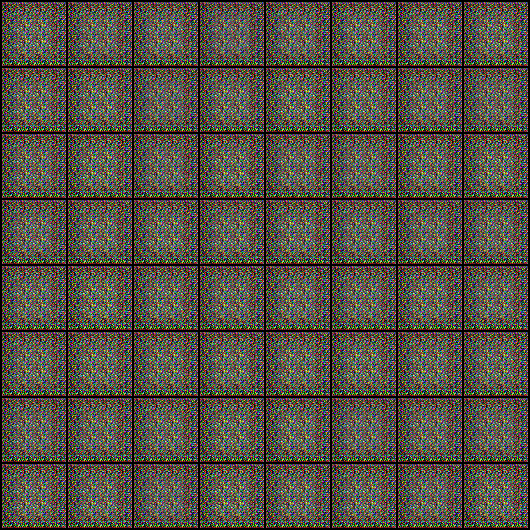

In [11]:
# Generar imágenes falsas
with torch.no_grad():
    noise = torch.randn(64, 100, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()
    vutils.save_image(fake_images, 'fake_images.png', normalize=True)

# Mostrar las imágenes generadas
display(Image.open('fake_images.png'))